In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from sys import path
path.append('/home/loris/software')
import thermocepstrum as tc
plt.rcParams['figure.figsize'] = (16, 9)
#import statsmodels.api as sm
#import pickle

Read the trajectory file, selecting the desired columns.

In [2]:
jfile = tc.io.LAMMPS_Current('Silica.dat', group_vectors=True)

# Solid Silica - BKS potential, melted and quenched
# 216 atoms, T~1000K, dens~2.295g/cm^3
# NVE, dt = 1.0 fs, 50 ns, output_step = 1.0 fs
# Temperature = 1065.705630 K, Volume = 3130.431110818 A^3
# LAMMPS metal units
c_flux1[1] c_flux1[2] c_flux1[3]
 #####################################
  all_ckeys =  {'flux1': array([0, 1, 2])}
 #####################################
Data length =  100001


In [3]:
jfile.read_currents(start_step=0, NSTEPS=0, select_ckeys=['flux1'])

  ckey =  {'flux1': array([0, 1, 2])}
    step =    100000 - 100.00% completed
  ( 100000 ) steps read.
DONE.  Elapsed time:  0.704571008682 seconds


{'flux1': array([[  91.472925,  630.61992 ,  199.16002 ],
        [  71.403952,  666.80601 ,  274.30247 ],
        [  47.754737,  678.10914 ,  305.95706 ],
        ..., 
        [ 466.489   , -360.14259 ,  -47.286976],
        [ 414.3014  , -378.42595 ,  166.42152 ],
        [ 331.99113 , -400.35311 ,  378.13009 ]])}

Define constants and conversion factors

In [4]:
DT_FS = 1.0                 # time step [fs]
TEMPERATURE = 1065.705630   # temperature [K]
VOLUME = 3130.431110818     # volume [A^3]
kappa_scale = tc.md.scale_kappa_METALtoSI(TEMPERATURE, VOLUME, DT_FS)

Define a MDSample from the trajectory

In [5]:
j = tc.md.MDSample(traj = jfile.data['flux1'], DT_FS=DT_FS)

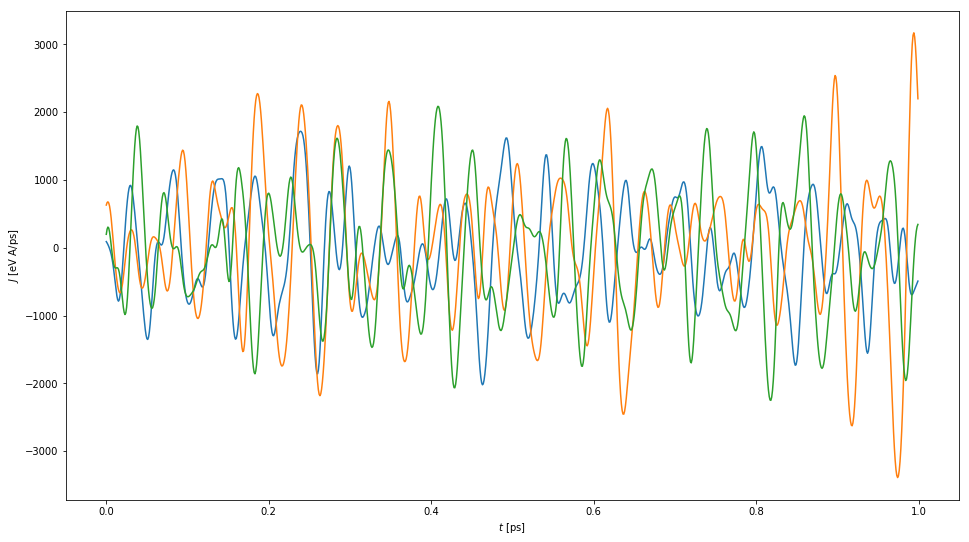

In [6]:
# trajectory
plt.plot(np.arange(1000)*j.DT_FS/1000., j.traj[:1000,:]);
plt.xlabel('$t$ [ps]')
plt.ylabel('$J$ [eV A/ps]');

Compute Power Spectral Density and filter it for visualization

In [7]:
FILTER_WINDOW_WIDTH = 0.0005  # filter window width [reduced frequency units]
j.compute_psd(FILTER_WINDOW_WIDTH, average_components=True)

In [8]:
print 'There are {:d} frequencies.'.format(j.Nfreqs)
print 'Nyquist frequency = {:f} THz'.format(j.Nyquist_f_THz)
print 'freqs = ', j.freqs_THz, 'THz'

There are 50001 frequencies.
Nyquist frequency = 500.000000 THz
freqs =  [  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   4.99980000e+02
   4.99990000e+02   5.00000000e+02] THz


(0.0, 100000000.0)

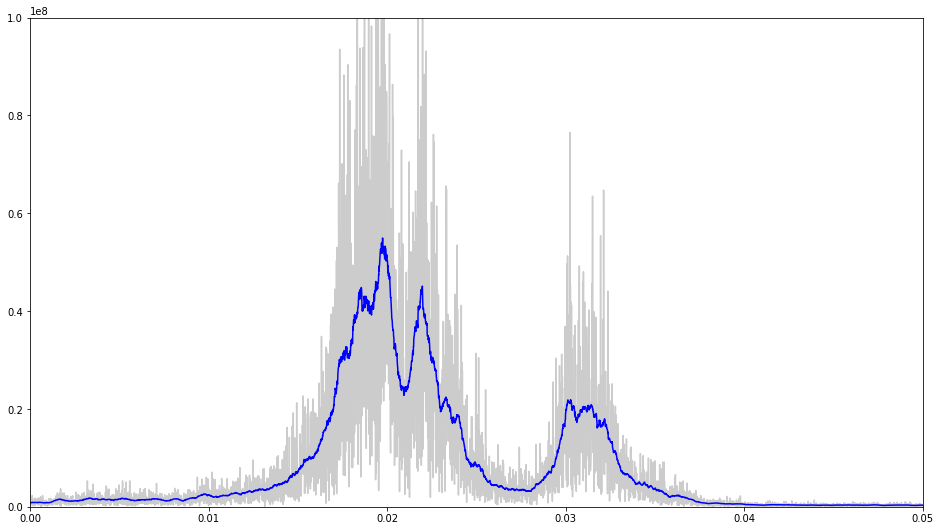

In [9]:
# PSD (in reduced units)
plt.plot(j.freqs, j.psd, '0.8')
plt.plot(j.freqs, j.fpsd, 'b')
plt.xlim([0., 0.05])
plt.ylim([0., 1e8])

Resample trajectory and recompute PSD.

In [10]:
TSKIP = int(round(0.5/0.028))
print 'Sampling time = {:d} steps = {:f} fs'.format(TSKIP, TSKIP*DT_FS)
jf = tc.md.MDSample(traj = tc.md.tools.filter_and_sample(j.traj, TSKIP, TSKIP), DT_FS=TSKIP*DT_FS)

Sampling time = 18 steps = 18.000000 fs


In [11]:
FILTER_WINDOW_WIDTH = 0.0005*TSKIP  # filter window width [reduced frequency units]
jf.compute_psd(FILTER_WINDOW_WIDTH, average_components=True, DT=TSKIP)  # DT is used to normalize the new PSD

In [12]:
print 'There are {:d} frequencies.'.format(jf.Nfreqs)
print 'Nyquist frequency = {:f} THz'.format(jf.Nyquist_f_THz)
print 'freqs = ', jf.freqs_THz, 'THz'

There are 2778 frequencies.
Nyquist frequency = 27.777778 THz
freqs =  [  0.00000000e+00   1.00028008e-02   2.00056016e-02 ...,   2.77577722e+01
   2.77677750e+01   2.77777778e+01] THz


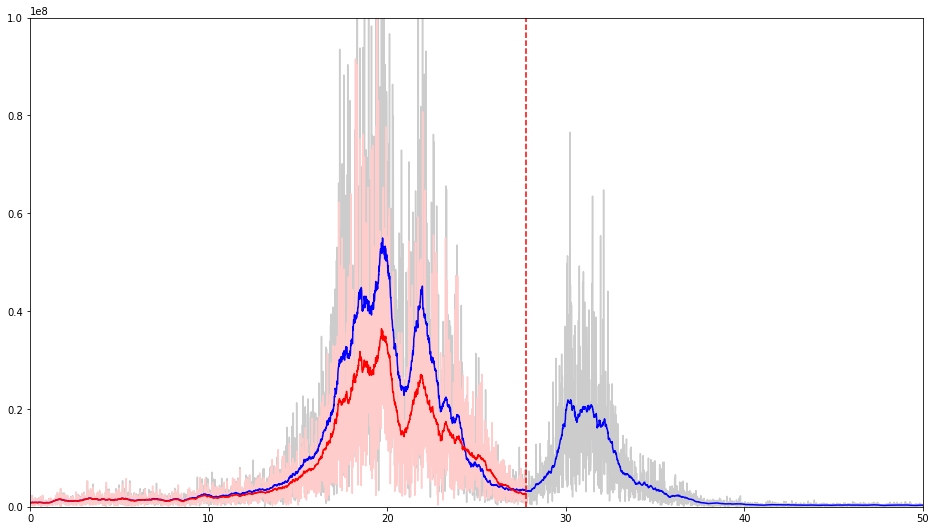

In [13]:
# PSD of resampled series (in THz)
plt.plot(j.freqs_THz, j.psd, '0.8')
plt.plot(jf.freqs_THz, jf.psd, '#FFCCCC')
plt.plot(j.freqs_THz, j.fpsd, 'b')
plt.plot(jf.freqs_THz, jf.fpsd, 'r')
plt.axvline(x=jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
plt.ylim([0., 1e8]);

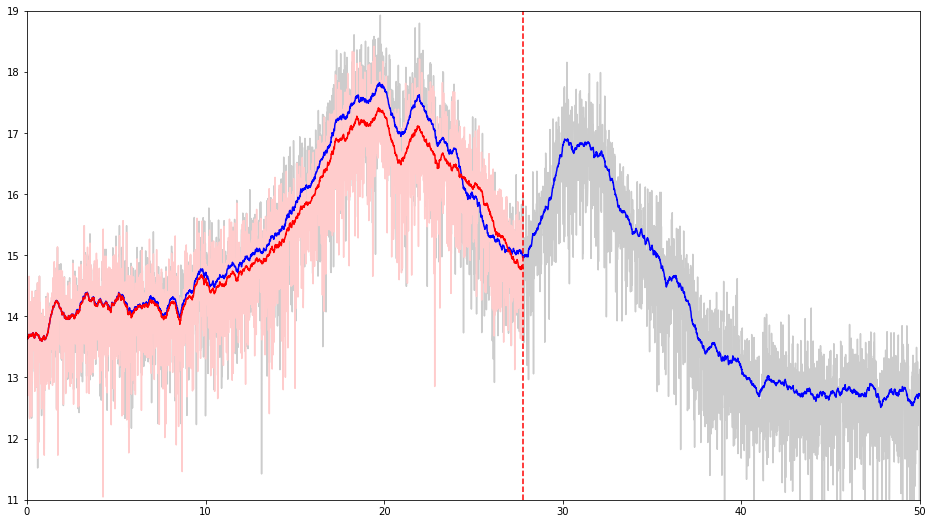

In [14]:
# log-PSD
plt.plot(j.freqs_THz, j.logpsd, '0.8')
plt.plot(jf.freqs_THz, jf.logpsd, '#FFCCCC')
plt.plot(j.freqs_THz, j.flogpsd, 'b')
plt.plot(jf.freqs_THz, jf.flogpsd, 'r')
plt.axvline(x=jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
plt.ylim([11., 19.]);

Compute theoretical distribution properties for Cepstral Analysis

In [15]:
ck_THEORY_var, psd_THEORY_mean = tc.md.cepstral.multicomp_cepstral_parameters(jf.Nfreqs, jf.N_COMPONENTS)

Cepstral Analysis: compute coefficients and AIC

In [16]:
jf.dct = tc.md.CosFilter(jf.logpsd, ck_theory_var=ck_THEORY_var, psd_theory_mean=psd_THEORY_mean, \
                         aic_type='aic', Kmin_corrfactor=1.0)

In [17]:
jf.dct.logpsdK_THEORY_std

array([ 0.01192544,  0.00843256,  0.00843256, ...,  0.00843256,
        0.00843256,  0.01192544])

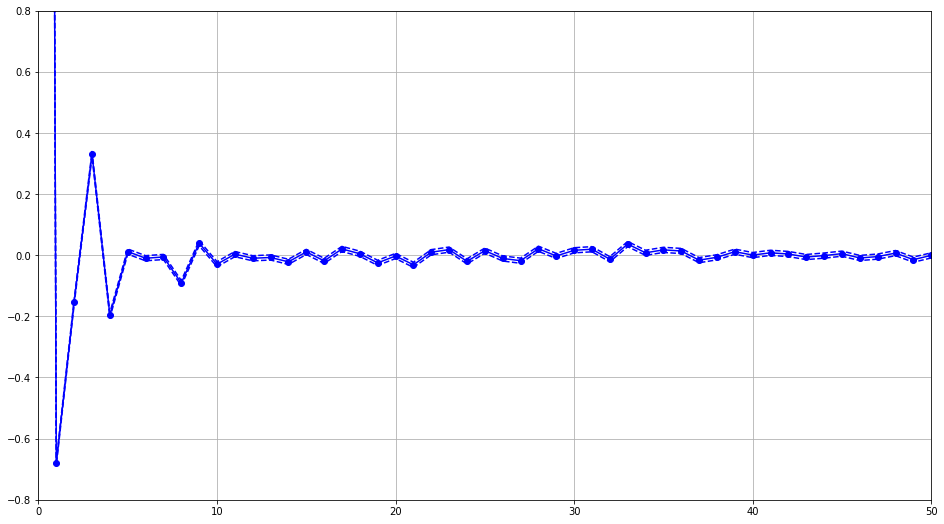

In [18]:
# Cepstral Coefficients
plt.plot(jf.dct.logpsdK, 'o-b')
plt.plot(jf.dct.logpsdK + jf.dct.logpsdK_THEORY_std, '--b')
plt.plot(jf.dct.logpsdK - jf.dct.logpsdK_THEORY_std, '--b')
plt.xlim([0,50])
plt.ylim([-0.8,0.8]);
plt.grid();

K of AIC_min = 37
AIC_min = 2820.804281


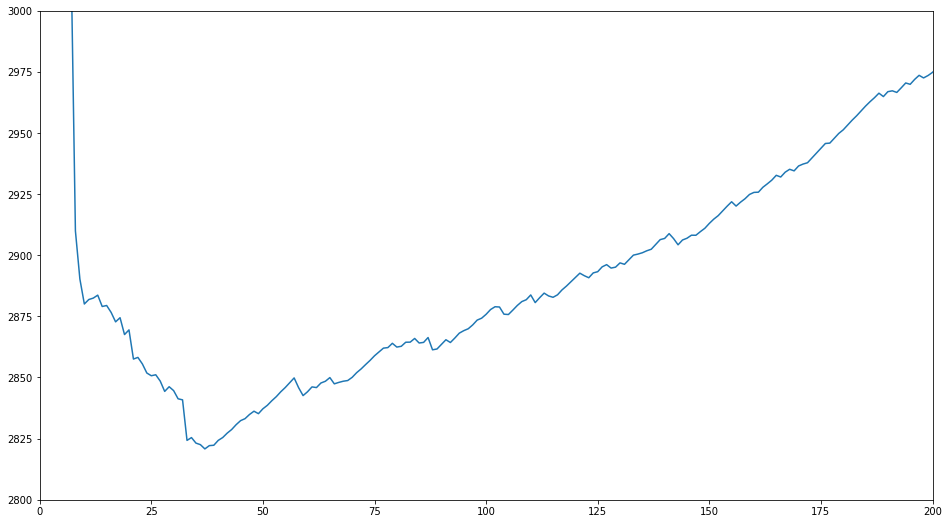

In [19]:
# AIC
plt.plot(jf.dct.aic)
plt.xlim([0,200])
plt.ylim([2800, 3000]);

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

Cepstral Analysis: compute $L_0$ (tau) as a function of the cutoff

In [20]:
jf.dct.scan_filter_tau()

K of AIC_min = 37
AIC_min = 2820.804281


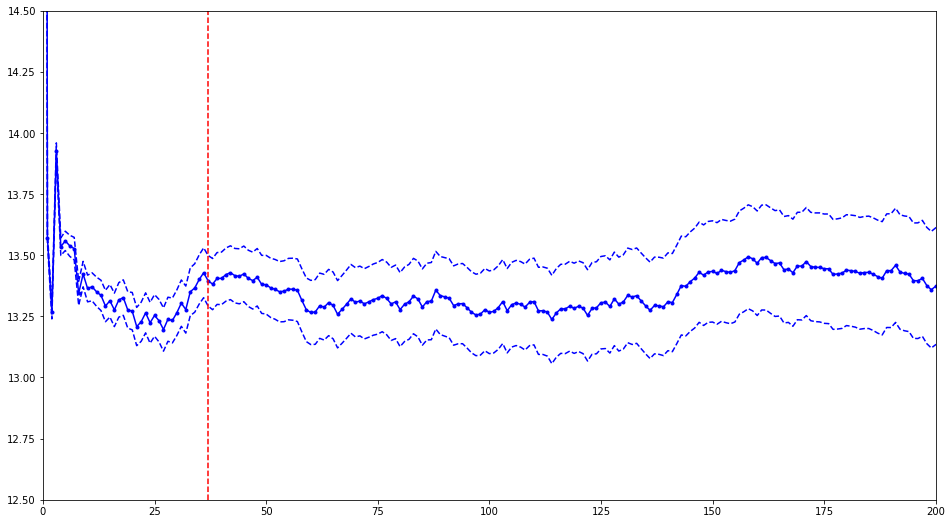

In [21]:
# L_0 as a function of cutoff K
plt.plot(jf.dct.logtau, '.-b')
plt.plot(jf.dct.logtau + jf.dct.logtau_THEORY_std, '--b')
plt.plot(jf.dct.logtau - jf.dct.logtau_THEORY_std, '--b')
plt.xlim([0,200])
plt.ylim([12.5, 14.5]);
plt.axvline(x=jf.dct.aic_Kmin, ls='--', c='r')

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

In [22]:
print 'L_0* = {:15f} +/- {:10f}'.format(jf.dct.logtau_Kmin, jf.dct.logtau_std_Kmin)
print 'S_0* = {:15f} +/- {:10f}'.format(jf.dct.tau_Kmin, jf.dct.tau_std_Kmin)

L_0* =       13.395456 +/-   0.103277
S_0* =   950203.538450 +/- 98134.481881


In [24]:
print 'kappa* = {:15f} +/- {:10f}  W/mK'.format(jf.dct.tau_Kmin * kappa_scale * 0.5, jf.dct.tau_std_Kmin * kappa_scale * 0.5)

kappa* =        2.484534 +/-   0.256596  W/mK
